In [2]:
# Final Copy for Netflow Day 2 Analysis-- Updated Reading in Data
# Catherine Beazley (cmb5et)
# 1/22/2018
# Completed this with 64GB Ram

In [3]:
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random

In [3]:
chunksize = 10000000
file = 'netflow_day-02.txt'
header = ['Time', 'Duration','SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort','SrcPackets','DstPackets',
         'SrcBytes','DstBytes']
reader = pd.read_table(file, sep=',', chunksize = chunksize, header = None)

In [4]:
numChunks = sum(1 for row in open('netflow_day-02.txt', 'r'))/chunksize

In [5]:
start = time.time()
df = pd.DataFrame()
count = 0
for chunk in reader:
    count += 1
    if count <= math.ceil(numChunks):
        df_chunk = chunk
        df_chunk.columns = header
        df_chunk = df_chunk.drop_duplicates(subset=['Time', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort'], keep='last')
        df_chunk["Time"] = pd.to_datetime(df_chunk["Time"], unit='s')
        df_chunk["Duration"] = df_chunk["Duration"].astype(int)
        df_chunk["Protocol"] = df_chunk["Protocol"].astype('category')
        df_chunk["SrcPackets"] = df_chunk["SrcPackets"].astype(int)
        df_chunk["DstPackets"] = df_chunk["DstPackets"].astype(int)
        df_chunk["SrcBytes"] = df_chunk["SrcBytes"].astype(int)
        df_chunk["DstBytes"] = df_chunk["DstBytes"].astype(int)  
        df = df.append(df_chunk)
    else:
        break
end = time.time()
end - start

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value i

478.87142062187195

In [4]:
start = time.time()
df = df.drop_duplicates(subset=['Time', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort'], keep='last')
end = time.time()
end - start

NameError: name 'df' is not defined

In [7]:
df.shape

(109523946, 11)

In [8]:
# Cosine Similarity (used in clustering algorithm)
def cosine_similarity(slope1, slope2):
    a = np.array([1,slope1])
    b = np.array([1,slope2])
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [9]:
# Cluster Packet Scatterplot
def slope_classifier(k, x_coords, y_coords):    
    # Randomly assigning initial clusters
    slopeClusters = []
    for i in range(k):
        slopeClusters.append((random.uniform(0,math.pi/2)))
    
    # Finding the ratio of y to x (slope for each (x,y) coordinate)
    # Making x values of 0 very small to avoid divide by zero error
    xCopy = x_coords
    xCopy[xCopy==0] = 0.0000000000000000000001
    y = np.array(y_coords, dtype = 'float')
    x = np.array(xCopy, dtype = 'float')
    slopes = np.divide(y,x)
    
    
    # Instantiating and empty array of 0 as a place holder for the old slope clusters
    # will use this to calculate error as slope clusters change each iteration. Once the error
    # is 0, the clusters have stabilized
    old_slopeClusters = np.zeros(len(slopeClusters))
    error = np.divide(np.subtract(slopeClusters, old_slopeClusters), old_slopeClusters)
  
    # Running a loop until centroids stabilize (percent change from old cluster values to new is 0)
    while error.any() != 0:
        
        # Instantiating an empty array of 0s that will be populated with cluster assignments for each slope  
        clusters = np.zeros(len(slopes))
        
        # For each slope, find the cosine distance to each cluster. Cosine always return [0,1], with values
        # closer to 1 signifying that the two vectors are close; 0 that they are far apart. Finding the max
        # cosine value and the corresponding cluster will be assigned to that slope. 
        for i in range(len(slopes)):               
            distances = []
            for j in range(len(slopeClusters)):
                distances.append(cosine_similarity(slopes[i],slopeClusters[j]))
            cluster = np.argmax(distances)
            clusters[i] = cluster
        
               
        # Making a deep copy of the old centroids to use later for clacluating error
        old_slopeClusters = deepcopy(slopeClusters)
        
        
        # Finding new centroids by taking average of the values assigned to each cluster and
        # replacing the old cluster values with the new averages
        for m in range(k):
            points = [slopes[j] for j in range(len(slopes)) if clusters[j] == m]              
            slopeClusters[m] = sum(points)/len(points)
        
        # Finding the percent change from the old cluster assignments to the new cluster assignments
        error = np.divide(np.subtract(slopeClusters, old_slopeClusters), old_slopeClusters)
        
    return clusters

In [10]:
# Taking a random subset of 10 million lines
df2 = df.sample(n=10000000, replace=False, random_state=941996)

In [11]:
# Checking that the random sample is what's expected
df2.shape

(10000000, 11)

In [ ]:
# Finding the centroid of one Protocol as a test
# 1. Subset the dataframe to only include 

In [12]:
df = df2

In [21]:
# Clustering the subsetted Data by DstPackets and SrcPackets
clusters = slope_classifier(3,df["SrcPackets"], df["DstPackets"])

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


In [22]:
# adding cluster assignments to subsetted dataframe and saving it to a csv for reproducability
df['SlopeClusterAssign'] = clusters
df.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes,SlopeClusterAssign
110608810,1970-01-02 23:00:51,0,Comp255696,Comp257274,6,Port78720,Port20301,2.000000e+00,4,112,216,1.0
12287378,1970-01-02 10:19:18,0,Comp826300,Comp275646,17,Port48708,53,1.000000e+00,0,69,0,0.0
44108309,1970-01-02 13:22:56,36,Comp120187,Comp708267,6,Port29614,80,7.000000e+00,6,711,1411,1.0
5872997,1970-01-02 09:46:44,1,Comp989973,Comp108157,17,Port74125,427,1.000000e-22,1,0,345,2.0
18153648,1970-01-02 10:49:50,12,Comp257274,Comp935614,6,Port55791,Port79662,5.000000e+00,0,286,0,0.0


In [23]:
df.to_csv('RandomSample10mill_withClusters.csv')

In [5]:
##### Reading in above csv
start = time.time()
df = pd.read_csv('RandomSample10mill_withClusters.csv')
end = time.time()
print(end - start)

FileNotFoundError: File b'RandomSample10mill_withClusters.csv' does not exist

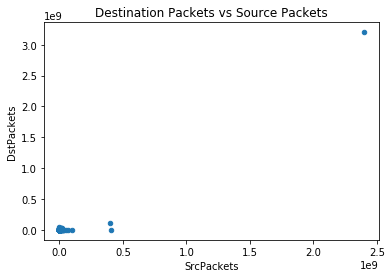

In [13]:
# Plot of DstPackets vs SrcPackets 
df.plot(x="SrcPackets", y="DstPackets", kind='scatter', title='Destination Packets vs Source Packets')
plt.show()
df.plot(x="SrcPackets", y="DstPackets", kind='scatter', 
                     c = clusters, title='Destination Packets vs Source Packets (Clustered Slopes)',
                     legend=True, colormap = 'Accent')
plt.show()

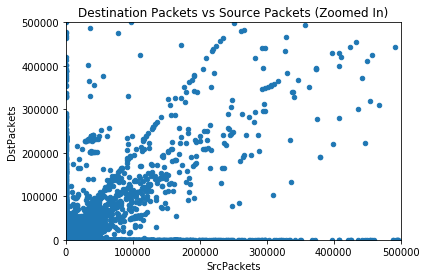

In [14]:
# Plot of DstPackets vs SrcPackets Zoomed in
df.plot(x="SrcPackets", y="DstPackets", kind='scatter', title='Destination Packets vs Source Packets (Zoomed In)')
plt.xlim([0, 500000])
plt.ylim([-3, 500000])
plt.show()



In [ ]:
# Plot of DstPackets vs SrcPackets Zoomed in and color coded by cluster
df.plot(x="SrcPackets", y="DstPackets", kind='scatter', 
                     c = clusters, title='Destination Packets vs Source Packets (Clustered Slopes)',
                     legend=True, colormap = 'Accent')
plt.xlim([0, 500000])
plt.ylim([-3, 500000])
plt.show()

In [11]:
# Setting the Data Up for PCA

In [15]:
# Taking Log of all Columns First
df2 = deepcopy(df[["Protocol", "Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]])
df2['Duration'] = np.log(df2['Duration'].loc[df2['Duration'] != 0])
df2['SrcPackets'] = np.log(df2['SrcPackets'].loc[df2['SrcPackets'] != 0])
df2['DstPackets'] = np.log(df2['DstPackets'].loc[df2['DstPackets'] != 0])
df2['SrcBytes'] = np.log(df2['SrcBytes'].loc[df2['SrcBytes'] != 0])
df2['DstBytes'] = np.log(df2['DstBytes'].loc[df2['DstBytes'] != 0])
df2.head()

,Protocol,Duration,SrcPackets,DstPackets,SrcBytes,DstBytes
110608810,6,NaN,0.693147,1.386294,4.718499,5.375278
12287378,17,NaN,0.000000,NaN,4.234107,NaN
44108309,6,3.583519,1.945910,1.791759,6.566672,7.252054
5872997,17,0.000000,NaN,0.000000,NaN,5.843544
18153648,6,2.484907,1.609438,NaN,5.655992,NaN


In [16]:
# Converting NaN to 0 
df2['Duration'] = np.nan_to_num(df2['Duration'])
df2['SrcPackets'] = np.nan_to_num(df2['SrcPackets'])
df2['DstPackets'] = np.nan_to_num(df2['DstPackets'])
df2['SrcBytes'] = np.nan_to_num(df2['SrcPackets'])
df2['DstBytes'] = np.nan_to_num(df2['DstBytes'])
df2.head()

,Protocol,Duration,SrcPackets,DstPackets,SrcBytes,DstBytes
110608810,6,0.000000,0.693147,1.386294,0.693147,5.375278
12287378,17,0.000000,0.000000,0.000000,0.000000,0.000000
44108309,6,3.583519,1.945910,1.791759,1.945910,7.252054
5872997,17,0.000000,0.000000,0.000000,0.000000,5.843544
18153648,6,2.484907,1.609438,0.000000,1.609438,0.000000


In [17]:
# Scaling
pre = preprocessing.scale(df2[["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]])
pre = pd.DataFrame.from_records(pre, columns = ["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"])
pre['Protocol'] = df["Protocol"].values
pre.head()

,Duration,SrcPackets,DstPackets,SrcBytes,DstBytes,Protocol
0,-0.480475,-0.290989,0.616281,-0.290989,0.642349,6
1,-0.480475,-0.836378,-0.573777,-0.836378,-0.926775,17
2,1.110104,0.694722,0.964351,0.694722,1.190208,6
3,-0.480475,-0.836378,-0.573777,-0.836378,0.779043,17
4,0.622475,0.429976,-0.573777,0.429976,-0.926775,6


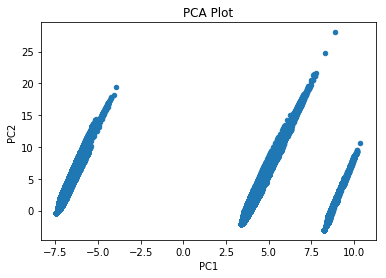

In [18]:
# PCA
pcaDF = pre[["Duration", "Protocol", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]]
pca = PCA(n_components=2).fit_transform(pre)
pcdf = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])
pcdf.plot(x="PC1", y="PC2", kind='scatter', title='PCA Plot')
plt.show()